# Importing packages

## Setup

In [203]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import open3d
import pptk
from logging import raiseExceptions
import seaborn as sns
import funcs
import tensorflow as tf

%reload_ext funcs


## Data loader

original dataframe size (1066, 18)
 dataframe (688, 4)


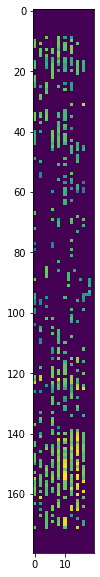

In [202]:
dataloader = funcs.DataLoader(modality='Radar' , data_type='matrix')
dataloader.get_data(filename='1_.txt')

print('original dataframe size', dataloader.dataframe_original.shape)
print(' dataframe',  dataloader.dataframe.shape )

plt.figure(figsize=(50,10))
plt.imshow(dataloader.data_matrix.T / dataloader.data_matrix.max() )

In [201]:
x,y,z = dataloader.spherical_to_cartesian( Azimuth_Angle=dataloader.dataframe.Azimuth , Elevation_Angle=dataloader.dataframe.Elevation - 10 , Range=dataloader.dataframe.Range )

# plt.hist(z)

dataloader.dataframe

,Range,Azimuth,Elevation,RCS
0,1,10,10,85
1,1,11,14,85
2,1,19,8,85
3,1,20,8,86
4,1,20,8,86
...,...,...,...,...
954,449,100,10,60
955,456,103,4,63
956,486,44,4,58
958,497,45,4,59


In [200]:
# dataloader.dataframe_original

## <span style="color:orange; font-size:0.8em"> Viewing the point clouds </span>

In [200]:
columns = dataloader.dataframe.columns[:3]

funcs.DataLoader().visualize(points=dataloader.dataframe[columns])

## <span style="color:orange; font-size:0.8em"> Vector Input </span>

In [199]:
loader = funcs.VectorInput(filename='1_.txt', modality='Radar')

print(loader.dataframe.shape)
print(loader.data.test.shape)

Epoch 1/5
13/13 [==============================] - 2s 84ms/step - loss: -720.1578 - val_loss: -996.6763
Epoch 2/5
13/13 [==============================] - 1s 40ms/step - loss: -979.6589 - val_loss: -996.6763
Epoch 3/5
13/13 [==============================] - 1s 45ms/step - loss: -974.2334 - val_loss: -996.6763
Epoch 4/5
13/13 [==============================] - 1s 52ms/step - loss: -966.9218 - val_loss: -996.6763
Epoch 5/5
13/13 [==============================] - 0s 36ms/step - loss: -996.1646 - val_loss: -996.6763
(688, 4)
(220, 4)


## <span style="color:orange; font-size:0.8em"> Matrix Input </span>

In [204]:
loader = funcs.MatrixInput(modality='Radar')

ValueError: `y` argument is not supported when using dataset as input.

tensorflow.python.data.ops.dataset_ops.TakeDataset

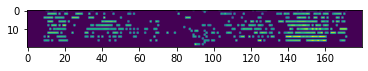

In [153]:
plt.imshow(list(loader.data.test.take(1))[0].numpy() )
plt.show()